In [2]:
import numpy as np
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image

# Data Preprocessing

Dataset shape: (672, 32, 32, 3)
Label shape: (672,)
(32, 32, 3)
[[0.7421875  0.46875    0.26953125]
 [0.78515625 0.49609375 0.2578125 ]
 [0.8046875  0.5        0.22265625]
 [0.8359375  0.53125    0.234375  ]
 [0.86328125 0.56640625 0.2890625 ]
 [0.8828125  0.59765625 0.3515625 ]
 [0.921875   0.61328125 0.3515625 ]
 [0.953125   0.640625   0.34375   ]
 [0.953125   0.6875     0.375     ]
 [0.9453125  0.71484375 0.4375    ]
 [0.6015625  0.37109375 0.1875    ]
 [0.59375    0.3515625  0.23046875]
 [0.50390625 0.25390625 0.15625   ]
 [0.46484375 0.22265625 0.08984375]
 [0.46875    0.21875    0.09765625]
 [0.4921875  0.23828125 0.11328125]
 [0.5234375  0.265625   0.125     ]
 [0.52734375 0.26171875 0.12109375]
 [0.52734375 0.2578125  0.12890625]
 [0.515625   0.26171875 0.12890625]
 [0.50390625 0.2578125  0.12109375]
 [0.4921875  0.25       0.12109375]
 [0.4609375  0.21875    0.08984375]
 [0.42578125 0.18359375 0.03515625]
 [0.86328125 0.62890625 0.42578125]
 [0.9765625  0.71484375 0.44140625]


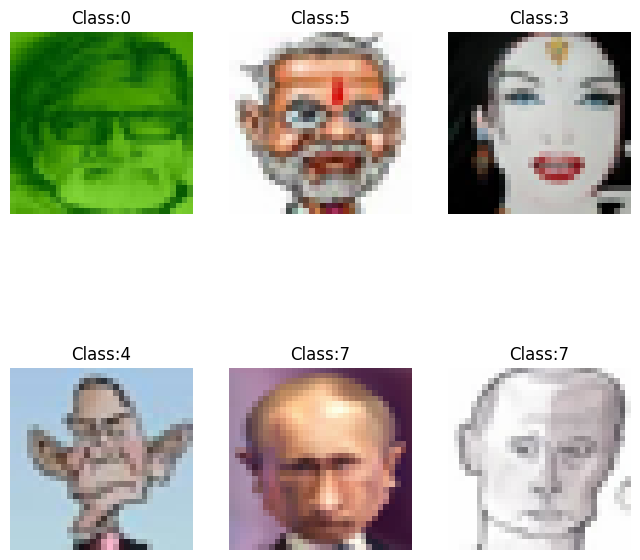

In [13]:
cfw_dict = {
    'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7
}

opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

def display_images(imgs,classes,row=1,col=2,w=32,h=32):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

def load_data(dir_path):
    image_list = []
    y_list = []
    label_dict = cfw_dict
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue
    image_list = np.array(image_list)
    y_list = np.array(y_list)
    print("Dataset shape:",image_list.shape)
    print("Label shape:",y_list.shape)

    return image_list,y_list


dirpath = 'PCA_DATA/IIIT-CFW/IIIT-CFW'
X,y = load_data(dirpath)
# print(y)
print(X[0].shape)
print(X[0][31])
# [[[a,b,c]....32 times]...32 times]
N,H,W = X.shape[0:3]
C = 1 if opt['is_grayscale'] else X.shape[3]

ind = np.random.randint(0,y.shape[0],6)
display_images(X[ind,...],y[ind], row=2,col=3)

Implementation of Principle Component Analysis